<a href="https://colab.research.google.com/github/AUT-Student/NLP-HW3/blob/main/NLP_HW3_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from gensim.models.word2vec import Word2Vec
import gensim.downloader as gensim_api

import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import LSTM, Dense, Input, Embedding, Bidirectional, TimeDistributed
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import backend as K
from keras.optimizer_v2.adam import Adam

# Dataset

In [2]:
!gdown 11WeeMttH6I6MJ0t1h7FVSEtw0lKwpRA6
!gdown 1gLGNxjQzy6C8y4Oivr8etU1MMGfuKuEE
!gdown 127-sOeW6KMf6XNSAVM3bGjfwnmW0NciU

Downloading...
From: https://drive.google.com/uc?id=11WeeMttH6I6MJ0t1h7FVSEtw0lKwpRA6
To: /content/dev.conll
100% 478k/478k [00:00<00:00, 52.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gLGNxjQzy6C8y4Oivr8etU1MMGfuKuEE
To: /content/test.conll
100% 677k/677k [00:00<00:00, 54.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=127-sOeW6KMf6XNSAVM3bGjfwnmW0NciU
To: /content/train.conll
100% 11.4M/11.4M [00:00<00:00, 61.4MB/s]


In [3]:
def dependency_create(row):
  dependency_index = row["DependencyIndex"]
  index = row["Index"]

  if dependency_index == 0:
    return "Root"
  else:
    different = dependency_index - index

    if different > 0:
      return f"{different}R"
    elif different < 0:
      return f"{abs(different)}L"
    else:
      raise Exception(row)

In [4]:
def load_and_preprocess_dataset(path):
  dataset = pd.read_csv(path, delimiter="\t", header=None, names=["Index", "Word", "DependencyIndex"])
  dataset = dataset.dropna()
  dataset["Index"] = dataset["Index"].astype(int)
  dataset["DependencyIndex"] = dataset["DependencyIndex"].astype(int)
  dataset["Dependency"] = dataset.apply(dependency_create, axis=1)

  return dataset

In [5]:
train_dataset = load_and_preprocess_dataset("/content/train.conll")
valid_dataset = load_and_preprocess_dataset("/content/dev.conll")
test_dataset = load_and_preprocess_dataset("/content/test.conll")

In [6]:
label_dictionary = {"PAD": 0}

for i, label in enumerate(set(train_dataset["Dependency"].values.tolist() +
                              valid_dataset["Dependency"].values.tolist() +
                              test_dataset["Dependency"].values.tolist())):
  label_dictionary[label] = i+1

In [7]:
number_labels = len(label_dictionary)

In [8]:
max_number_sequence = max(max(train_dataset["Index"].values), max(valid_dataset["Index"].values), max(test_dataset["Index"].values))

# Embedding

In [9]:
print(gensim_api.load("word2vec-google-news-300", return_path=True))
print(gensim_api.load("glove-wiki-gigaword-300", return_path=True))

/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
/root/gensim-data/glove-wiki-gigaword-300/glove-wiki-gigaword-300.gz


In [10]:
word2vec_model = gensim_api.load("word2vec-google-news-300")
glove_model = gensim_api.load("glove-wiki-gigaword-300")

# Sequence Dataset

In [11]:
def convert_to_sequence(dataset):
  sequenced_dataset = []

  for i, item in dataset.iterrows():
    if item["Index"] == 1:
      if i>0:
        sequenced_dataset.append({"Words": new_words, "Labels": new_labels})
      new_words = [item["Word"]]
      new_labels = [item["Dependency"]]
    else:
      new_words.append(item["Word"])
      new_labels.append(item["Dependency"])
  
  sequenced_dataset.append({"Words": new_words, "Labels": new_labels})
  return pd.DataFrame(sequenced_dataset)

In [12]:
train_dataset = convert_to_sequence(train_dataset)
valid_dataset = convert_to_sequence(valid_dataset)
test_dataset = convert_to_sequence(test_dataset)

In [13]:
def create_apply_embedding(embedding_model):
  def apply_embedding(row):
    vectors = []
    for word in row["Words"]:
      try:
        vector = embedding_model.get_vector(word)
      except KeyError:
        vector = np.zeros(300)
      vectors.append(vector)

    for i in range(141-len(row["Words"])):
      vectors.append(np.zeros(300))

    return np.stack(vectors)

  return apply_embedding

In [14]:
def apply_label_index(row):
  labels = []
  for label in row["Labels"]:
    labels.append(label_dictionary[label])

  for i in range(max_number_sequence-len(row["Labels"])):
    labels.append(label_dictionary["PAD"])
  
  return np.stack(labels)

In [15]:
class DatasetGenerator(keras.utils.Sequence):
  def __init__(self, dataset, batch_size, embedding_model):
    self.dataset = dataset
    self.batch_size = batch_size
    self.apply_embedding = create_apply_embedding(embedding_model)

  def __len__(self):
    return math.ceil(len(self.dataset)/self.batch_size)
  
  def __getitem__(self, idx):
    batch_vectors = np.stack(self.dataset.iloc[idx * self.batch_size : (idx+1) * self.batch_size].apply(self.apply_embedding, axis=1).values)
    batch_labelindex = np.stack(self.dataset.iloc[idx * self.batch_size : (idx+1) * self.batch_size].apply(apply_label_index, axis=1).values)

    return batch_vectors, batch_labelindex

In [23]:
# valid_dataset["Vector"] = valid_dataset.apply(apply_embedding, axis=1)
# valid_dataset["LabelIndex"] = valid_dataset.apply(apply_label_index, axis=1)
# test_dataset["Vector"] = test_dataset.apply(apply_embedding, axis=1)
# test_dataset["LabelIndex"] = test_dataset.apply(apply_label_index, axis=1)

In [26]:
train_dataset_generator = DatasetGenerator(dataset=train_dataset, batch_size=32, embedding_model=word2vec_model)
valid_dataset_generator = DatasetGenerator(dataset=valid_dataset, batch_size=32, embedding_model=word2vec_model)
test_dataset_generator = DatasetGenerator(dataset=test_dataset, batch_size=32, embedding_model=word2vec_model)

# BiLSTM Model

In [23]:
class BiLSTM(keras.Model):
  def __init__(self, number_lstm_cells):
    super().__init__()
    self.model = Sequential([
                             Input((max_number_sequence, 300)),
                             Bidirectional(LSTM(number_lstm_cells, return_sequences=True)),
                             TimeDistributed(Dense(number_labels, activation="softmax"))
    ])
  
  def call(self, inputs):
    return self.model(inputs)

In [24]:
def ignore_class_accuracy(to_ignore=0):
   # Refrence: https://nlpforhackers.io/lstm-pos-tagger-keras/
  
  def ignore_accuracy(y_true, y_pred):
    y_pred_class = K.argmax(y_pred, axis=-1)
    y_true_class = K.argmax(y_true, axis=-1)
    y_true_class = K.cast(y_true, "int64")

    ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
    matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
    accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
    return accuracy
  
  return ignore_accuracy

In [25]:
bilstm_model = BiLSTM(64)

In [27]:
bilstm_model.compile(optimizer=Adam(0.01), loss="sparse_categorical_crossentropy", metrics=["Accuracy", ignore_class_accuracy(0)])

In [28]:
es_callback = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

In [29]:
history = bilstm_model.fit(x=train_dataset_generator,
                           epochs=20, callbacks=[es_callback],
                           validation_data=valid_dataset_generator)

Epoch 1/20
1245/1245 [==============================] - 50s 38ms/step - loss: 0.2403 - Accuracy: 0.9382 - ignore_accuracy: 0.6488 - val_loss: 0.1681 - val_Accuracy: 0.9530 - val_ignore_accuracy: 0.7239
Epoch 2/20
1245/1245 [==============================] - 48s 39ms/step - loss: 0.1490 - Accuracy: 0.9574 - ignore_accuracy: 0.7531 - val_loss: 0.1445 - val_Accuracy: 0.9591 - val_ignore_accuracy: 0.7600
Epoch 3/20
1245/1245 [==============================] - 46s 37ms/step - loss: 0.1310 - Accuracy: 0.9619 - ignore_accuracy: 0.7793 - val_loss: 0.1369 - val_Accuracy: 0.9606 - val_ignore_accuracy: 0.7694
Epoch 4/20
1245/1245 [==============================] - 46s 37ms/step - loss: 0.1211 - Accuracy: 0.9644 - ignore_accuracy: 0.7944 - val_loss: 0.1313 - val_Accuracy: 0.9625 - val_ignore_accuracy: 0.7807
Epoch 5/20
1245/1245 [==============================] - 46s 37ms/step - loss: 0.1157 - Accuracy: 0.9659 - ignore_accuracy: 0.8032 - val_loss: 0.1298 - val_Accuracy: 0.9630 - val_ignore_accurac

# Evaluation

In [47]:
bilstm_model.evaluate(test_dataset_generator)
    # np.stack(test_dataset["Vector"].values),
    #                   np.stack(test_dataset["LabelIndex"].values))

76/76 [==============================] - 4s 50ms/step - loss: 0.1475 - Accuracy: 0.9586 - ignore_accuracy: 0.7566


[0.14749988913536072, 0.9585564136505127, 0.7566297650337219]

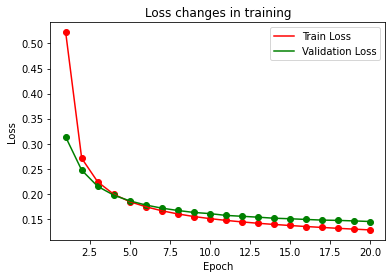

In [ ]:
train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]

plt.scatter(range(1, len(train_loss)+1), train_loss, color="red")
plt.scatter(range(1, len(train_loss)+1), valid_loss, color="green")

plt.plot(range(1, len(train_loss)+1), train_loss, color="red", label="Train Loss")
plt.plot(range(1, len(train_loss)+1), valid_loss, color="green", label="Validation Loss")

plt.legend()
plt.title("Loss changes in training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()